**<font size="+3">06 Stationarität</font>**

https://de.wikipedia.org/wiki/Station%C3%A4rer_stochastischer_Prozess  
https://towardsdatascience.com/time-series-from-scratch-stationarity-tests-and-automation-14b02fa5ca4d#:~:text=A%20time%20series%20has%20to,doesn't%20change%20over%20time.

https://towardsdatascience.com/stationarity-in-time-series-a-comprehensive-guide-8beabe20d68

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

In [3]:
from IPython.display import Markdown as md      # Formatierte Ausgabe aus einer Code-Zelle
from statsmodels.tsa.stattools import adfuller  # AFD-test für Stationarität
from statsmodels.tsa.stattools import kpss      # KPSS-test für Stationarität

In [4]:
passengers = pd.read_csv('data/airline-passengers.csv', index_col='Month', parse_dates=True)

Die folgenden Datensätze stammen von:<br>
Hyndman RJ (2023). fma: Data sets from "Forecasting: methods and applications" by Makridakis, Wheelwright & Hyndman (1998). R package version 2.5.0.9000, http://pkg.robjhyndman.com/fma/.

In [5]:
# Annual number of strikes in the US (hyndman)
strikes    = pd.read_csv('data/strikes.csv', sep=';', index_col='year')
# Annual total of lynx trapped in the McKenzie River district of north-west Canada
lynx    = pd.read_csv('data/lynx.csv', sep=';', index_col='year')
# Monthly Australian Beer Production
beer    = pd.read_csv('data/beer.csv', sep=';', index_col='month', parse_dates=True)
# IBM stock prive for 386 consecutive days
ibm    = pd.read_csv('data/ibm.csv', sep=';', index_col='time')

# Begriffsklärung

**Vorbemerkung**  
<ul>
<li>Es gibt eine starke und eine schwache Stationarität
    <li>bei Zeitreihen geht es idR nur um die <b>schwache Stationarität</b>
<li>wird nur von Stationarität (bei Zeitreihen) gesprochen, ist idR die schwache Stationarität gemeint
<li>über die starke Stationarität wird daher im Folgenden nicht mehr gesprochen
</ul>

**(schwache) Stationarität**  
<ul>
<li>ist eine Eigenschaft eines stochastischen Prozesses (und damit auch von Zeitreihen)
<li>besagt, dass sich die statistischen Eigenschaften mit der Zeit nicht ändern
<li>ist eine Zeitreihe stationär, sind Eigenschaften ermittelbar, die über die Zeit hinweg gelten
<li>Eine Zeitreihe ist stationär, wenn
    <ul>
    <li>sich der Erwartungswert (Mittelwert) der Zeitreihe sich mit der Zeit nicht ändert
    <li>sich die Varianz (emp. Varianz) der Zeitreihe mit der Zeit nicht ändert
    <li>sich die Kovarianzen zwischen Werten die einen fixen zeitlichen Abstand besitzen, sich mit der Zeit nicht ändern
    </ul>
</ul>

**Weitere Begriffe: Spezielle nichtstationäre Zeitreihen**  
<ul>
<li>Trendstationär: nach dem Entfernen des (deterministischen) Trends wird Zeitreihe stationär.
<li>Differenzenstationär: nach einer Differenzierung ist die Zeitreihe stationär.
</ul>

# Visuelle Prüfung

**Eigenschaften bei Stationarität:**  
<ul>
<li>die Werte schwanken um einen bestimmten Wert herum (konstanter Mittelwert)
<li>die Größe der Schwankungen ändert sich nicht im Zeitablauf (konstante Varianz)
<li>bei der Zeitreihe ist kein Trend erkennbar
<li>es gibt keine regelmäßige Saisonkomponente
<li>die Werte verhalten sich in Teilen der Zeitreihe gleich
<li>es gibt nicht viele Ausreißer
</ul>

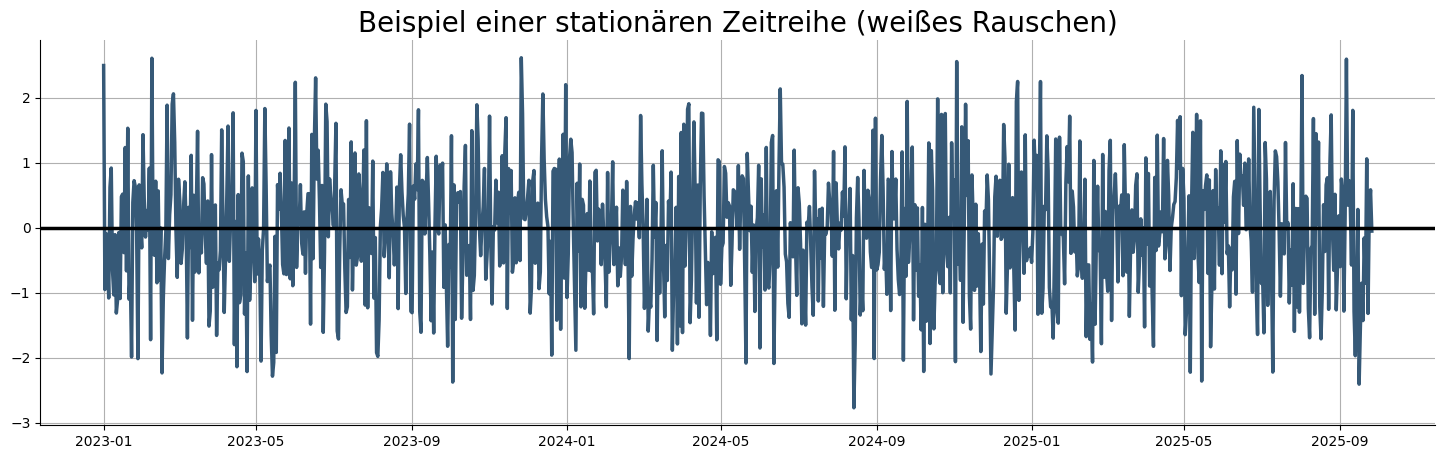

In [6]:
white_noise_values = np.random.randn(1000)

start = pd.Timestamp(2023, 1, 1)
dti = pd.date_range(start, periods= 1000, freq='d')  # datetimeindex

white_noise = pd.DataFrame(white_noise_values, index= dti, columns=['values'])

# Plot
plt.title('Beispiel einer stationären Zeitreihe (weißes Rauschen)', size=20)
plt.plot(white_noise.index, white_noise.values)
plt.axhline(y=0, color='black', linestyle='-')
plt.grid();

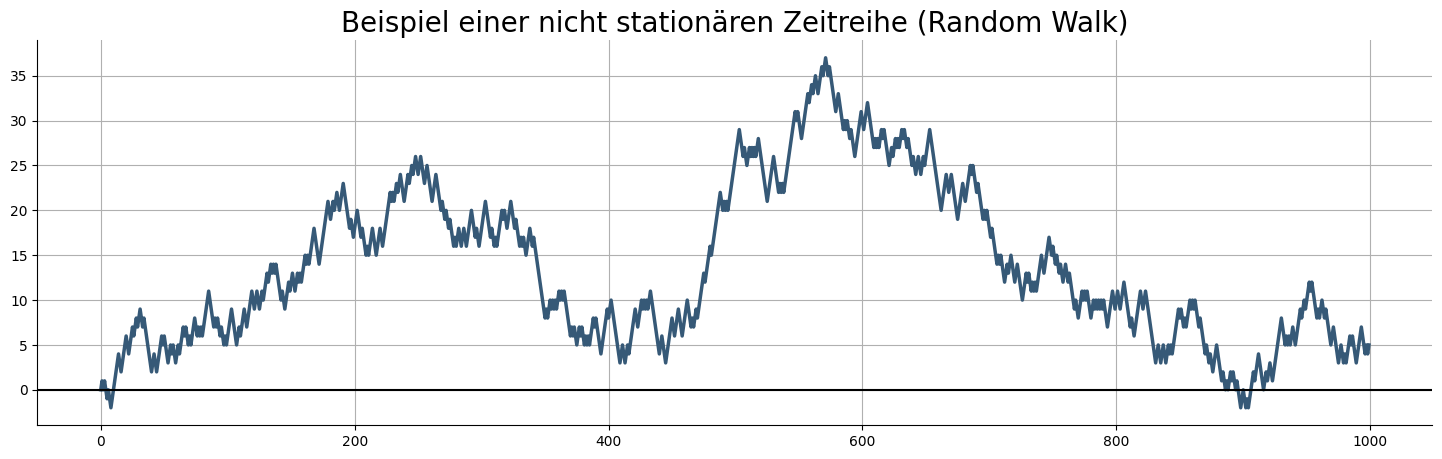

In [7]:
# Start with a random number - let's say 0
random_walk = [0]

#np.random.seed(12345)
for i in range(1, 1000):
    # Movement direction based on a random number
    num = -1 if np.random.random() < 0.5 else 1
    random_walk.append(random_walk[-1] + num)
    
# Plot
plt.title('Beispiel einer nicht stationären Zeitreihe (Random Walk)', size=20)
plt.plot(np.arange(len(random_walk)), random_walk)
plt.axhline(y=0, color='black', linestyle='-',linewidth=1.5)
plt.grid();

**Erstelle random walks mit jeweils 10 mal so vielen Daten.**

**Warum ist ein Random Walk nicht stationär?**

Antwort: Weil die Streuung mit zunehmender Zeit zunimmt.

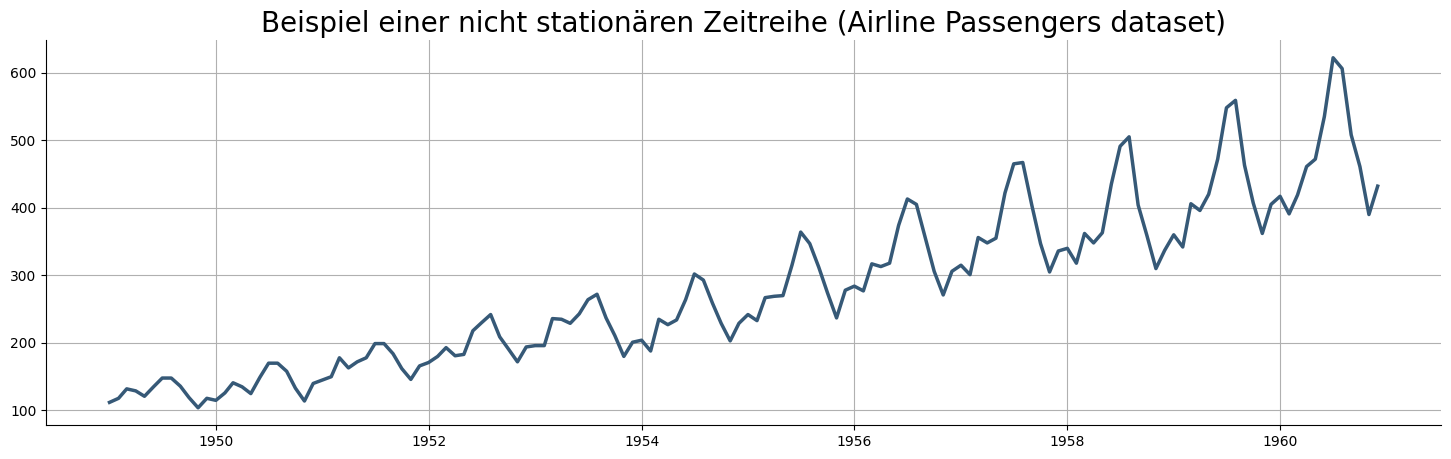

In [8]:
# Dataset

# Visualize
plt.title('Beispiel einer nicht stationären Zeitreihe (Airline Passengers dataset)', size=20)
plt.plot(passengers.index,passengers.Passengers)
plt.grid();

**Weitere Beispiele (Hyndman)**<br>
https://otexts.com/fpp2/stationarity.html

<img src="pics/Examples_Stationarity.JPG" alt="Drawing" style="width: 1000px;"/>

**Warum ist Zeitreihe 3 stationär, Zeitreihe 4 aber nicht?**

Ein Zeitreihe mit einer regelmäßigen Saisonkomponente (jeden Sommer sind die Werte größer) ist nicht stationär.<br>
Stellt euch vor, dass die Zeitreihe eine Realisation der Fole von Zufallsvariablen ist.<br>
Bei anderen Realisationen dieses stochastischen Prozesses wird immer der Erwartungswert im Sommer über dem im Winter liegen. Daher keine konstanter "Mittelwert".<br>
Bei den Luxen sind die Zyklen nicht regelmäßig.<br>
"But these cycles are aperiodic — they are caused when the lynx population becomes too large for the available feed, so that they stop breeding and the population falls to low numbers, then the regeneration of their food sources allows the population to grow again, and so on. In the long-term, the timing of these cycles is not predictable. Hence the series is stationary."<br>

# ADF-Test

https://de.wikipedia.org/wiki/Hypothese_(Statistik)<br>
https://de.wikipedia.org/wiki/Dickey-Fuller-Test#ADF-Test<br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

**ADF Test**  
<ul>
<li>ADF-Test = Augmented Dicky-Fuller test
<li>ist der üblichste statistische Test zur Prüfung der Stationarität einer Zeitreihe
<li><b>H0: Zeitreihe ist nicht stationär (Nullhypothese)</b>
<li><b>H1: Zeitreihe ist stationär (Alternativhypothese)</b>
<li>Info: bei 'kleinen' p-Werten wird H0 verworfen
</ul>

<b>
Parameter "Regression" bei adfuller()
</b>

| Parameter | Beschreibung | Bemerkungen |
|:----------|:------------|:-----------|
| c         | constant only | default - das ist OK für uns |
| ct        | constant and trend | damit wird "trendstationär" geprüft - eine Form der Instationarität |
| ctt       | constant, and linear and quadratic trend |
| n         | no constant, no trend.|  sinnvoll bei sehr kleinem Trend und Mittelwert nahe bei 0|

In [9]:
adf = adfuller(passengers.Passengers)
adf

(np.float64(0.8153688792060482),
 np.float64(0.991880243437641),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

In [10]:
print('Teststatistik: ',adf[0])
print('p-Wert:        ',adf[1])
print('Anzahl der verwendeten Lags:',adf[2])
print('Anzahl der verwendeten Datenpunkte:',adf[3])
print('Kritischer Wert bei 1%: ', list(adf[4].values())[0])
print('Kritischer Wert bei 5%: ', list(adf[4].values())[1])
print('Kritischer Wert bei 10%:', list(adf[4].values())[2])
print('Schätzwert des maximalen Informationskriteriums:',adf[5])

Teststatistik:  0.8153688792060482
p-Wert:         0.991880243437641
Anzahl der verwendeten Lags: 13
Anzahl der verwendeten Datenpunkte: 130
Kritischer Wert bei 1%:  -3.4816817173418295
Kritischer Wert bei 5%:  -2.8840418343195267
Kritischer Wert bei 10%: -2.578770059171598
Schätzwert des maximalen Informationskriteriums: 996.692930839019


**Analyse des Ergebnisses:**
<ul>
<li>allgemein: wenn der p-Wert < 0.05 => H0 wird zum Signifikanzniveau von 5% verworfen.
<li>allgemein: der Betrag der Teststatistik ist größer als der Betrag der entsprechenden kristischen Werte
<li>hier ist der p-Wert = 0.99 > 0.05, d.h. H0 wird zum Niveau nicht verworfen
<li>dh, dass die Zeitreihe NICHT stationär ist, wird NICHT verworfen
<li>wir gehen davon aus, dass die Zeitreihe nicht stationär ist
    </ul>

**Kriterien für Nicht-Stationarität:**  
<ul>
<li>der p-Wert ist größer als 0.05
<li>die Betrag der Teststatistik ist größer als der Betrag der kritischen Werte
</ul>

## White Noise

<b>Weißes Rauschen ist der Prototyp für Stationarität</b>

In [11]:
p_value = adfuller(white_noise)[1]
print('p-Wert des ADF-Tests : ',f'{p_value:.15f}'  )
if p_value < 0.05:
    print('Zeitreihe wird als stationär angesehen (zum Niveau 5%).')
else:
    print('Zeitreihe wird NICHT als stationär angesehen (zum Niveau 5%).')

p-Wert des ADF-Tests :  0.000000000000000
Zeitreihe wird als stationär angesehen (zum Niveau 5%).


## Random Walk

<b>Random Walks sind nicht stationar, da die Varianz mit der Zeit zunimmt.</b>

In [12]:
p_value = adfuller(random_walk)[1]
print('p-Wert des ADF-Tests : ',f'{p_value:.2f}'  )
if p_value < 0.05:
    print('Zeitreihe wird als stationär angesehen (zum Niveau 5%).')
else:
    print('Zeitreihe wird NICHT als stationär angesehen (zum Niveau 5%).')

p-Wert des ADF-Tests :  0.27
Zeitreihe wird NICHT als stationär angesehen (zum Niveau 5%).


## Passagierdaten

In [13]:
p_value = adfuller(passengers.Passengers)[1]
print('p-Wert des ADF-Tests : ',f'{p_value:.2f}'  )
if p_value < 0.05:
    print('Zeitreihe wird als stationär angesehen (zum Niveau 5%).')
else:
    print('Zeitreihe wird NICHT als stationär angesehen (zum Niveau 5%).')

p-Wert des ADF-Tests :  0.99
Zeitreihe wird NICHT als stationär angesehen (zum Niveau 5%).


# KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

<b>
Parameter "Regression" bei kpss()
</b>

| Parameter | Beschreibung | Bemerkungen |
|:----------|:------------|:-----------|
| c         | The data is stationary around a constant. |  |
| ct        | The data is stationary around a trend. |  |

**KPSS-Test**  
<ul>
<li>Kwiatkowski-Philipps-Schmidt-Shin Test
    <li>H0: die Zeitreihe <b>ist stationär</b> (das ist anders als beim ADF !!!)
    <li>H1: die Zeitreihe ist <b>nicht stationär</b>
</ul>

<b>
Bei kpss() kommt häufig eine Warnmeldung.<br>
Inhalt der Meldung: p-Werte > 0.1 werden als 0.1 dargestellt.</b>

In [14]:
kpss_test = kpss(passengers.Passengers, regression = "ct")
kpss_test

C:\Users\nylux\AppData\Local\Temp\ipykernel_19760\3218457979.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(passengers.Passengers, regression = "ct")


(np.float64(0.09614984853532418),
 np.float64(0.1),
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [15]:
print('Teststatistik: ',kpss_test[0])
print('p-Wert (wenn 0.1, dann mind. 0.1): ',kpss_test[1])
print('Anzahl der verwendeten Lags: ',kpss_test[2])
print('Kritischer Wert bei 10.0%: ', list(kpss_test[3].values())[0])
print('Kritischer Wert bei  5.0%: ', list(kpss_test[3].values())[1])
print('Kritischer Wert bei  2.5%: ', list(kpss_test[3].values())[2])
print('Kritischer Wert bei  1.0%: ', list(kpss_test[3].values())[2])

Teststatistik:  0.09614984853532418
p-Wert (wenn 0.1, dann mind. 0.1):  0.1
Anzahl der verwendeten Lags:  4
Kritischer Wert bei 10.0%:  0.119
Kritischer Wert bei  5.0%:  0.146
Kritischer Wert bei  2.5%:  0.176
Kritischer Wert bei  1.0%:  0.176


# ADF-Test und KPSS Test

**Hier werden beide Tests mit verschiedenen Parametern bei "Regression" miteinander verglichen.<br>
Für verschiedene Zeitreihen wird der ADF- und der KPSS Test mt verschiedenen Parameter durchgeführt.**

Die Ergebnisse stellen eine Erweiterung der Untersuchungen des folgenden Beitrags dar:<br>
https://towardsdatascience.com/stationarity-in-time-series-a-comprehensive-guide-8beabe20d68

In [16]:
# Ausschalten der Warnmeldungen von KPSS
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Erzeugen der Differenzierung der IBM-Aktienkurse
ibm_diff = ibm.diff()[1:]

In [18]:
# Ausschalten Warnmeldungen (wegen Warnmeldungen KPSS)
import warnings
warnings.filterwarnings('ignore')

timeseries = [ white_noise,  random_walk,  passengers,  strikes,  lynx,  beer,  ibm,  ibm_diff]
names      = ['white_noise','random_walk','passengers','strikes','lynx','beer','ibm','ibm_diff']

params_adf  = ['c','ct','ctt','n']  # Parameter bei ADF
params_kpss = ['c','ct']            # Parameter bei KPSS

p= []  # Sammlung der Namen der Zeitreihen und der p-Werte
for i in range(len(timeseries)):
    p = p + [names[i]]
    for par_adf in params_adf:
        p = p + [f'{ adfuller(timeseries[i], regression = par_adf)[1]   :.2f}']
    for par_kpss in params_kpss:
        pval = f'{ kpss(timeseries[i], regression = par_kpss)[1]   :.2f}'
        p = p + [pval]

Der folgende (versteckte) Latex-Befehl spart etwas Platz: "\newcommand{\h}[1]{{\hspace #1}}"
$\newcommand{\h}[1]{{\hspace #1}}$

In [19]:
display( \
md("Zeitreihe $\h{15pt}$ | ADF$_c$    | ADF$_{ct}$ | ADF$_{ctt}$ | ADF$_n$    || KPSS$_c$    | KPSS$_{ct}$ |<br> \
    %s        $\h{04pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{00pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{06pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{23pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{31pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{29pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{32pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
    %s        $\h{18pt}$ |$\h{6pt}$%s |$\h{6pt}$%s |$\h{10pt}$%s |$\h{6pt}$%s ||$\h{11pt}$%s |$\h{12pt}$%s |<br> \
   "%(p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10],p[11],p[12],p[13],p[14],p[15],p[16],p[17],p[18],p[19],p[20],p[21],p[22],p[23],p[24],p[25],p[26],p[27],p[28],p[29],p[30],p[31],p[32],p[33],p[34],p[35],p[36],p[37],p[38],p[39],p[40],p[41],p[42],p[43],p[44],p[45],p[46],p[47],p[48],p[49],p[50],p[51],p[52],p[53],p[54],p[55])))

Zeitreihe $\h{15pt}$ | ADF$_c$    | ADF$_{ct}$ | ADF$_{ctt}$ | ADF$_n$    || KPSS$_c$    | KPSS$_{ct}$ |<br>     white_noise        $\h{04pt}$ |$\h{6pt}$0.00 |$\h{6pt}$0.00 |$\h{10pt}$0.00 |$\h{6pt}$0.00 ||$\h{11pt}$0.10 |$\h{12pt}$0.10 |<br>     random_walk        $\h{00pt}$ |$\h{6pt}$0.27 |$\h{6pt}$0.54 |$\h{10pt}$0.62 |$\h{6pt}$0.31 ||$\h{11pt}$0.02 |$\h{12pt}$0.01 |<br>     passengers        $\h{06pt}$ |$\h{6pt}$0.99 |$\h{6pt}$0.55 |$\h{10pt}$0.20 |$\h{6pt}$1.00 ||$\h{11pt}$0.01 |$\h{12pt}$0.10 |<br>     strikes        $\h{23pt}$ |$\h{6pt}$0.31 |$\h{6pt}$0.52 |$\h{10pt}$0.92 |$\h{6pt}$0.46 ||$\h{11pt}$0.10 |$\h{12pt}$0.10 |<br>     lynx        $\h{31pt}$ |$\h{6pt}$0.05 |$\h{6pt}$0.14 |$\h{10pt}$0.34 |$\h{6pt}$0.22 ||$\h{11pt}$0.10 |$\h{12pt}$0.10 |<br>     beer        $\h{29pt}$ |$\h{6pt}$0.11 |$\h{6pt}$0.70 |$\h{10pt}$0.16 |$\h{6pt}$0.09 ||$\h{11pt}$0.10 |$\h{12pt}$0.10 |<br>     ibm        $\h{32pt}$ |$\h{6pt}$0.78 |$\h{6pt}$0.71 |$\h{10pt}$0.86 |$\h{6pt}$0.41 ||$\h{11pt}$0.01 |$\h{12pt}$0.01 |<br>     ibm_diff        $\h{18pt}$ |$\h{6pt}$0.00 |$\h{6pt}$0.00 |$\h{10pt}$0.00 |$\h{6pt}$0.00 ||$\h{11pt}$0.06 |$\h{12pt}$0.08 |<br>    

Bei KPSS bedeutet "0.10": p-Wert >= 0.10<br>
Bei KPSS bedeutet "0.01": p-Wert <= 0.10<br>

<b>white_noise</b><br>
ADF: stationär + trendstationär<br>
KPSS: stationär + trendstationär<br>
<b>random_walk</b><br>
ADF: nicht stationär + nicht trendstationär<br>
KPSS: nicht stationär + nicht trendstationär<br>
<b>passengers</b><br>
ADF: nicht stationär + nicht trendstationär<br>
KPSS: nicht stationär + trendstationär<br>
<b>strikes</b><br>
ADF: nicht stationär + nicht trendstationär<br>
KPSS: stationär + trendstationär<br>
<b>lynx</b><br>
ADF: grenze stationär + nicht trendstationär<br>
KPSS: stationär + trendstationär<br>
<b>beer</b><br>
ADF: nicht stationär + nicht trendstationär<br>
KPSS: stationär + trendstationär<br>
<b>ibm</b><br>
ADF: nicht stationär + nicht trendstationär<br>
KPSS: nicht stationär + nicht trendstationär<br>
<b>ibm_diff</b><br>
ADF: stationär + trendstationär<br>
KPSS: stationär + trendstationär<br>

**Anscheinend gilt ein Zeitreihe nur dann als stationär, wenn das beide Tests anzeigen.**

Die folgenden Aussagen sind aus dem folgenden Beitrag entnommen:<br>
https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

<b>(KPSS = S) + (ADF = NS):</b><br>
* The series is trend stationary.
* Trend needs to be removed to make series strict stationary.
* The detrended series is checked for stationarity.<br>

<b>(KPSS = NS) + (ADF = S):</b><br>
* The series is difference stationary.
* Differencing is to be used to make series stationary.
* The differenced series is checked for stationarity.

# Warum das Ganze

**Viele Zeitreihen sind nicht stationär - warum dann dei Beschäftigung mit Stationarität?**  
<ul>
<li>Modelle für nichtstationäre Zeitrehien basieren häufig auf Modellen von stationären Zeitreihen (Bsp.: ARIMA)
<li>es gibt Methoden, um auch Nicht-stationären Zeitreihen stationäre Zeitreihen zu machen:<br>
    Differenzierung, Logarithmierung, Entfernung Trend, Entfernung Saison)
<li>es gibt Prognoseverfahren, die nur bei einer Stationarität von Zeitreihen sinnvoll einsetzbar sind
</ul>

# Aufgaben

## Versuche über differenzieren alle Zeitreihen stationär zu bekommen.